# Integrating `Action Graph Service` into `Action` and `ActionObject` Creation

We aim to add an action node whenever an action occurs, or when an action object is created

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig
from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
from syft.service.response import SyftError
from syft.types.syft_object import SyftObjectRegistry

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pprint import pprint

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft


Failed to find type for key: __slots__ in <class 'typing._UnionGenericAlias'>
Failed to find type for key: _value in <class 'result.result.Err'>
Failed to find type for key: __slots__ in <class 'typing._UnionGenericAlias'>
Failed to find type for key: _monitor_socket in <class 'zmq.green.core._Socket'>
Failed to find type for key: value in <enum 'NodeType'>
Failed to find type for key: value in <enum 'ServiceRole'>
Failed to find type for key: value in <enum 'ActionPermission'>
Failed to find type for key: settings in <class 'syft.store.document_store.StorePartition'>
Failed to find type for key: protocol in <class 'syft.types.grid_url.GridURL'>
Failed to find type for key: value in <enum 'CMPCRUDPermission'>
Failed to find type for key: value in <enum '_ParameterKind'>
Failed to find type for key: _name in <class 'inspect.Parameter'>
Failed to find type for key: value in <enum 'VPNRoutes'>
Failed to find type for key: value in <enum 'CommandStatus'>
Failed to find type for key: value 

In [2]:
worker = sy.Worker.named(name="test", reset=True, processes=1)
authed_context = AuthedServiceContext(node=worker, 
                                      credentials=worker.signing_key.verify_key)

# node = sy.orchestra.launch(name="test-domain-1", port=8080, dev_mode=True, reset=True)
# domain_client = node.login(email="info@openmined.org", password="changethis")

root_client = worker.root_client
guest_client = worker.guest_client

assert root_client.credentials != guest_client.credentials

action_service = worker.get_service("actionservice")
action_graph_service = worker.get_service("actiongraphservice")
print(action_service.store)
print(action_graph_service.store)

assert isinstance(action_graph_service, ActionGraphService)
assert isinstance(action_graph_service.store, InMemoryActionGraphStore)

SQLite Store Path:
!open file:///tmp/9f86d081884c4d659a2feaa0c55ad015.sqlite



## Action / Action Object Creation

#### There are 2 places where we add a new `action_object`:
    - when we upload a new dataset
    - when someone send a piece of data to us

#### First scenario: Create and upload a dataset

In [3]:
num_assets = 2

In [4]:
dataset = sy.Dataset(name="Test Dataset")
dataset.set_description("""Test Dataset""")
dataset.add_citation("Person, place or thing")

country = sy.DataSubject(name="Country", aliases=["country_code"])
canada = sy.DataSubject(name="Canada", aliases=["country_code:ca"])
country.add_member(canada)
registry = root_client.data_subject_registry
response = registry.add_data_subject(country)

for i in range(num_assets):
    data = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))
    mock = pd.DataFrame(np.random.randint(0, 100, size=(10, 4)), 
                      columns=list('ABCD'))

    ctf = sy.Asset(name=f"test_dataset_{i}")
    ctf.set_description("""all the datas""")
    ctf.set_obj(data)
    ctf.set_shape((10, 4))
    ctf.add_data_subject(canada)
    ctf.set_mock(mock, mock_is_real=False)
    dataset.add_asset(ctf)

In [5]:
root_client.upload_dataset(dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.80it/s]


Uploading: test_dataset_0
Uploading: test_dataset_1


<class 'syft.service.response.SyftSuccess'>: Dataset Added

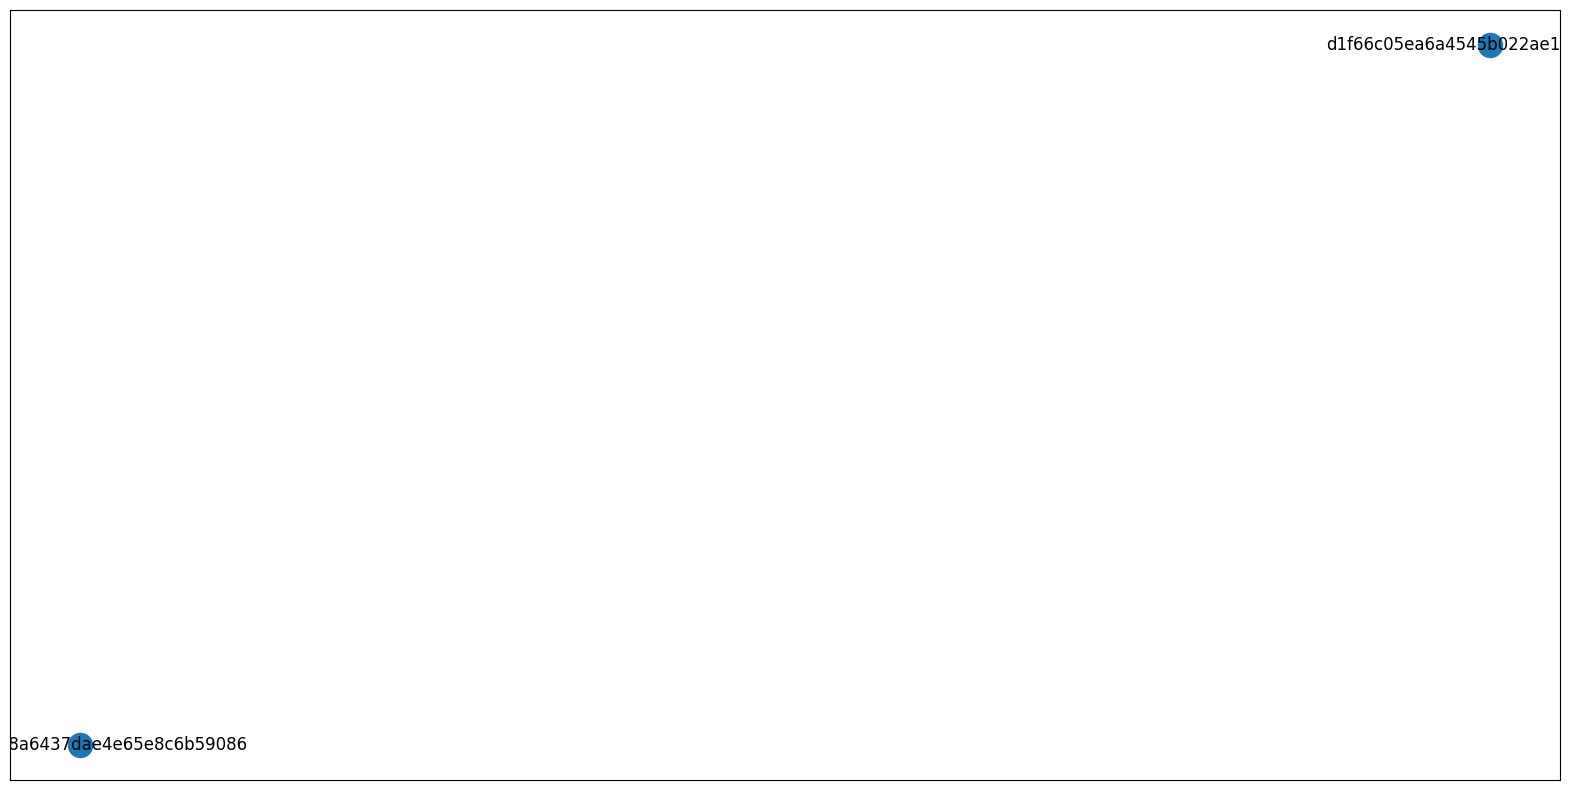

In [6]:
action_graph_service.visualize(context=authed_context)

In [7]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 2: Create a node when `action_obj.send` method is called

In [8]:
action_obj_a = ActionObject.from_obj([2, 4, 6])

In [9]:
action_obj_a.send(root_client)

Pointer:
[2, 4, 6]

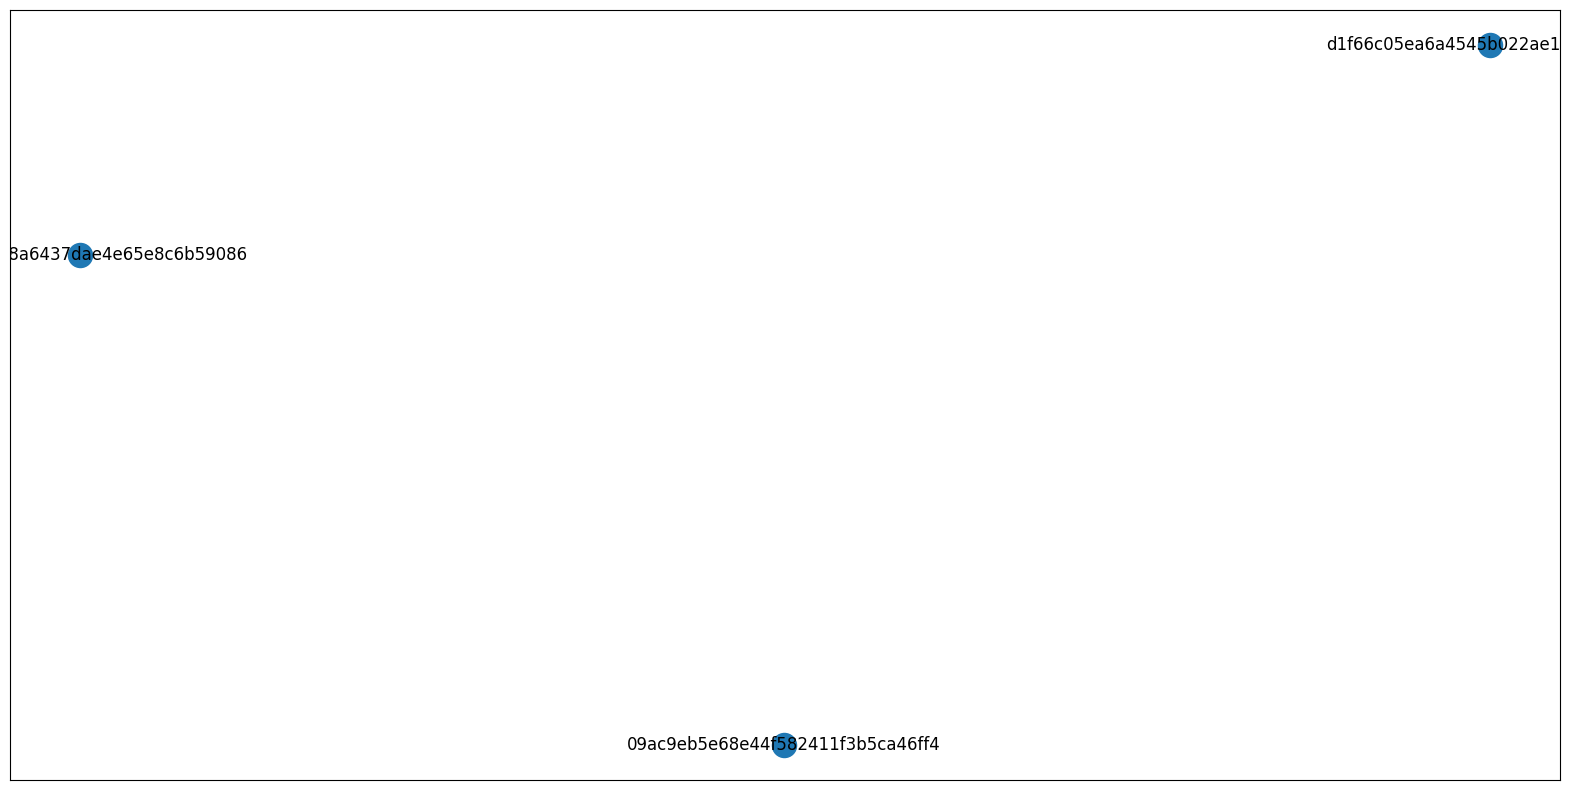

In [10]:
action_graph_service.visualize(context=authed_context)

In [11]:
assert action_graph_service.get(action_obj_a.id, authed_context).id == action_obj_a.id

In [12]:
assert len(action_graph_service.get_all_nodes(authed_context)) == num_assets + 1
assert len(action_graph_service.get_all_edges(authed_context)) == 0

#### Scenario 3: Create a graph node when an `Action` is created in `generate_remote_lib_function` in `packages/syft/src/syft/client/api.py`

New worker with a different database and in-memory graph

In [13]:
worker2 = sy.Worker.named(name="test2", processes=1, reset=True)

action_service2 = worker2.get_service("actionservice")
action_graph_service2 = worker2.get_service("actiongraphservice")

SQLite Store Path:
!open file:///tmp/60303ae22b994861bce3b28f33eec1be.sqlite



In [14]:
b = worker2.root_client.api.lib.numpy.array([1,2,3])

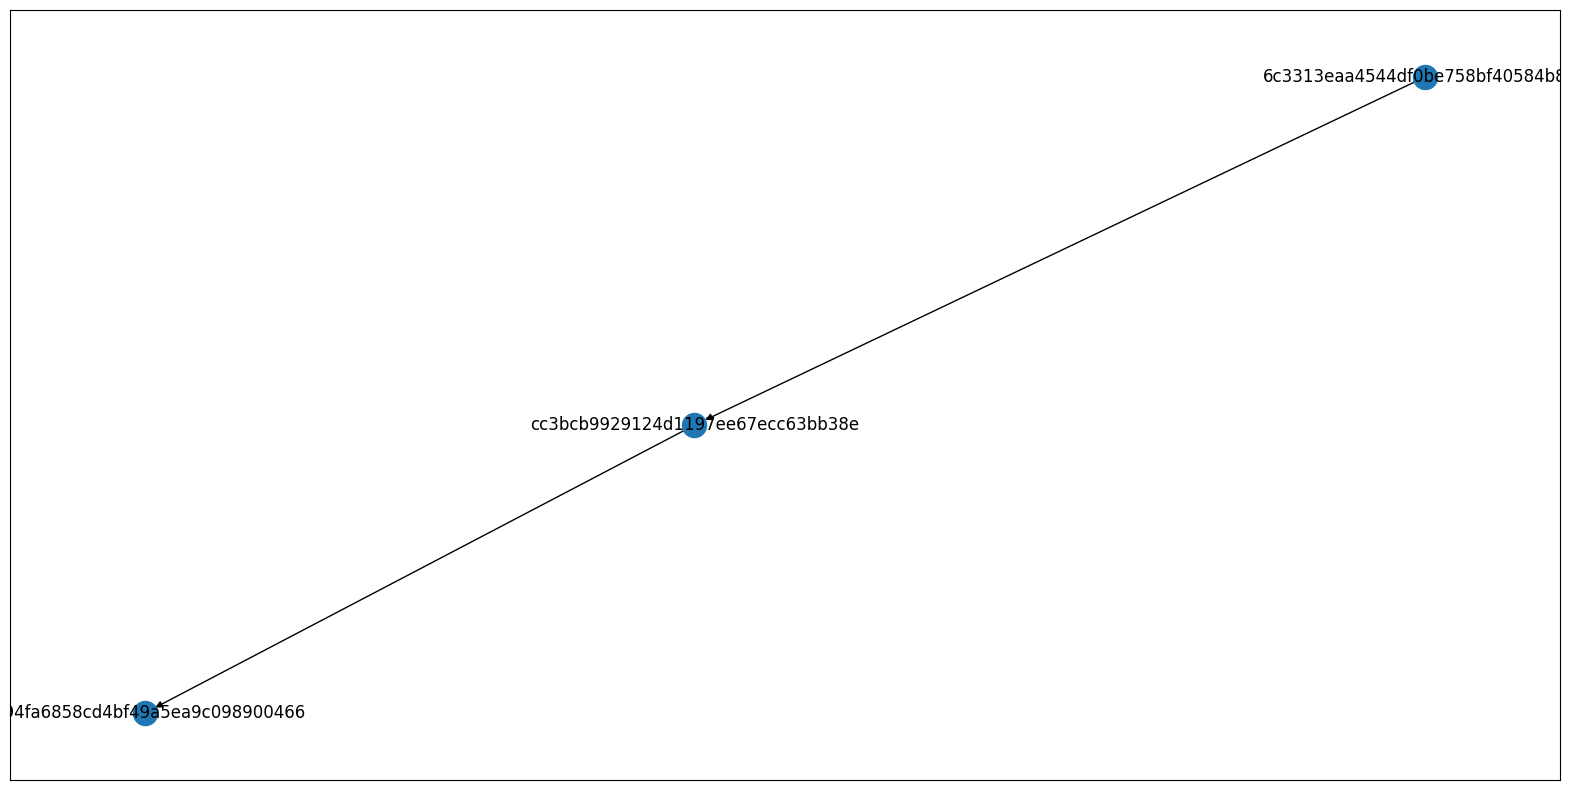

In [15]:
action_graph_service2.visualize(context=authed_context)

In [16]:
assert len(action_graph_service2.get_all_nodes(authed_context)) == 3
assert len(action_graph_service2.get_all_edges(authed_context)) == 2

In [17]:
worker2.action_store.data

{<UID: 6c3313eaa4544df0be758bf40584b802>: Pointer:
[1, 2, 3], <UID: c894fa6858cd4bf49a5ea9c098900466>: Pointer:
[1 2 3]}

In [18]:
list(worker2.action_graph_store.graph.db.nodes)

,type,id
0,<UID: 6c3313eaa4544df0be758bf40584b802>,6c3313eaa4544df0be758bf40584b802
1,<UID: cc3bcb9929124d1197ee67ecc63bb38e>,cc3bcb9929124d1197ee67ecc63bb38e
2,<UID: c894fa6858cd4bf49a5ea9c098900466>,c894fa6858cd4bf49a5ea9c098900466


In [19]:
c = worker2.guest_client.api.lib.numpy.array([2,3,4])

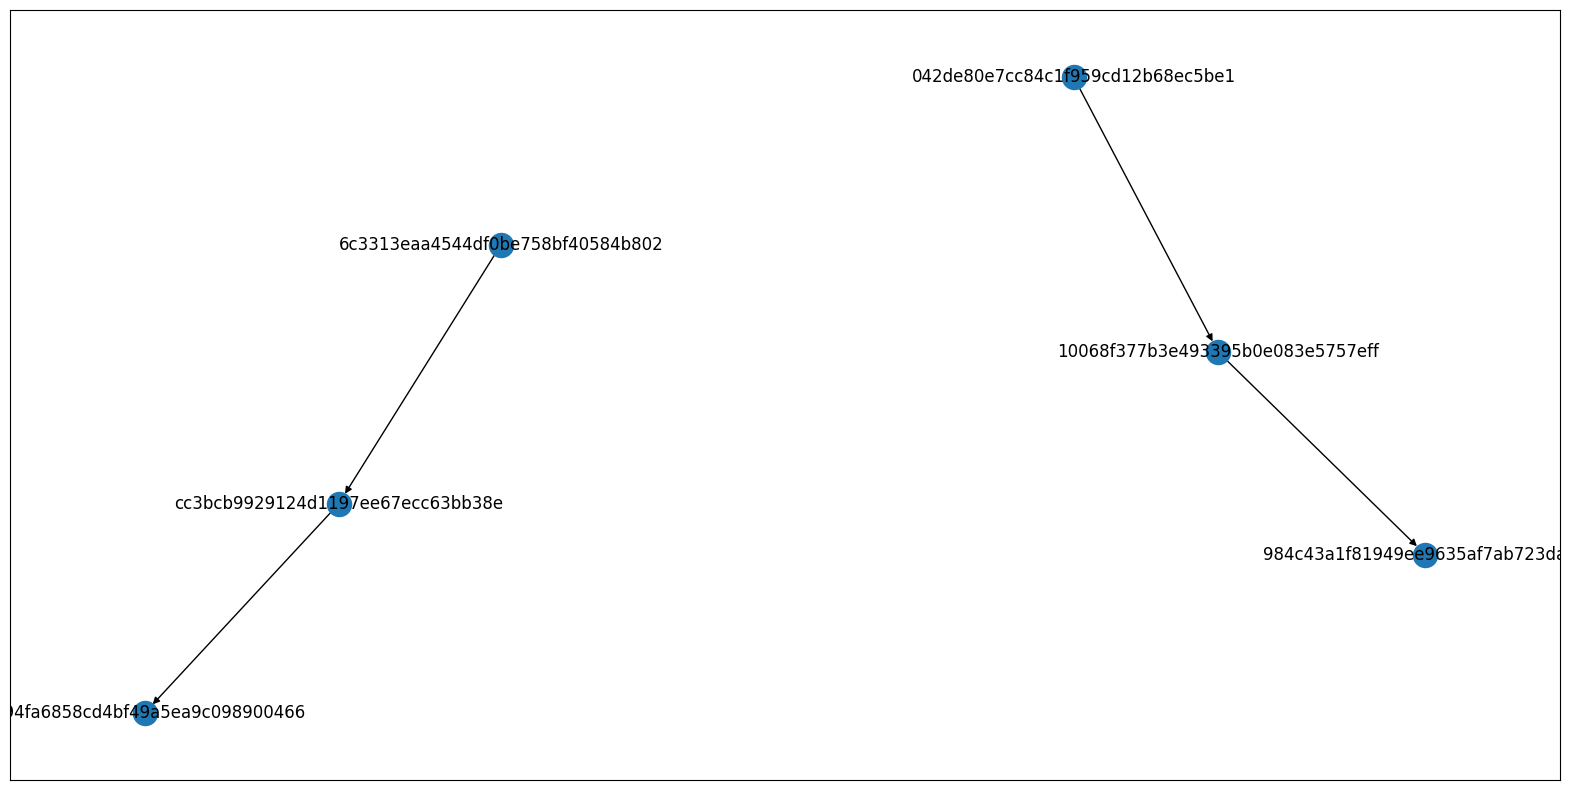

In [20]:
action_graph_service2.visualize(context=authed_context)

In [21]:
e = worker2.guest_client.api.lib.numpy.add(c, b)

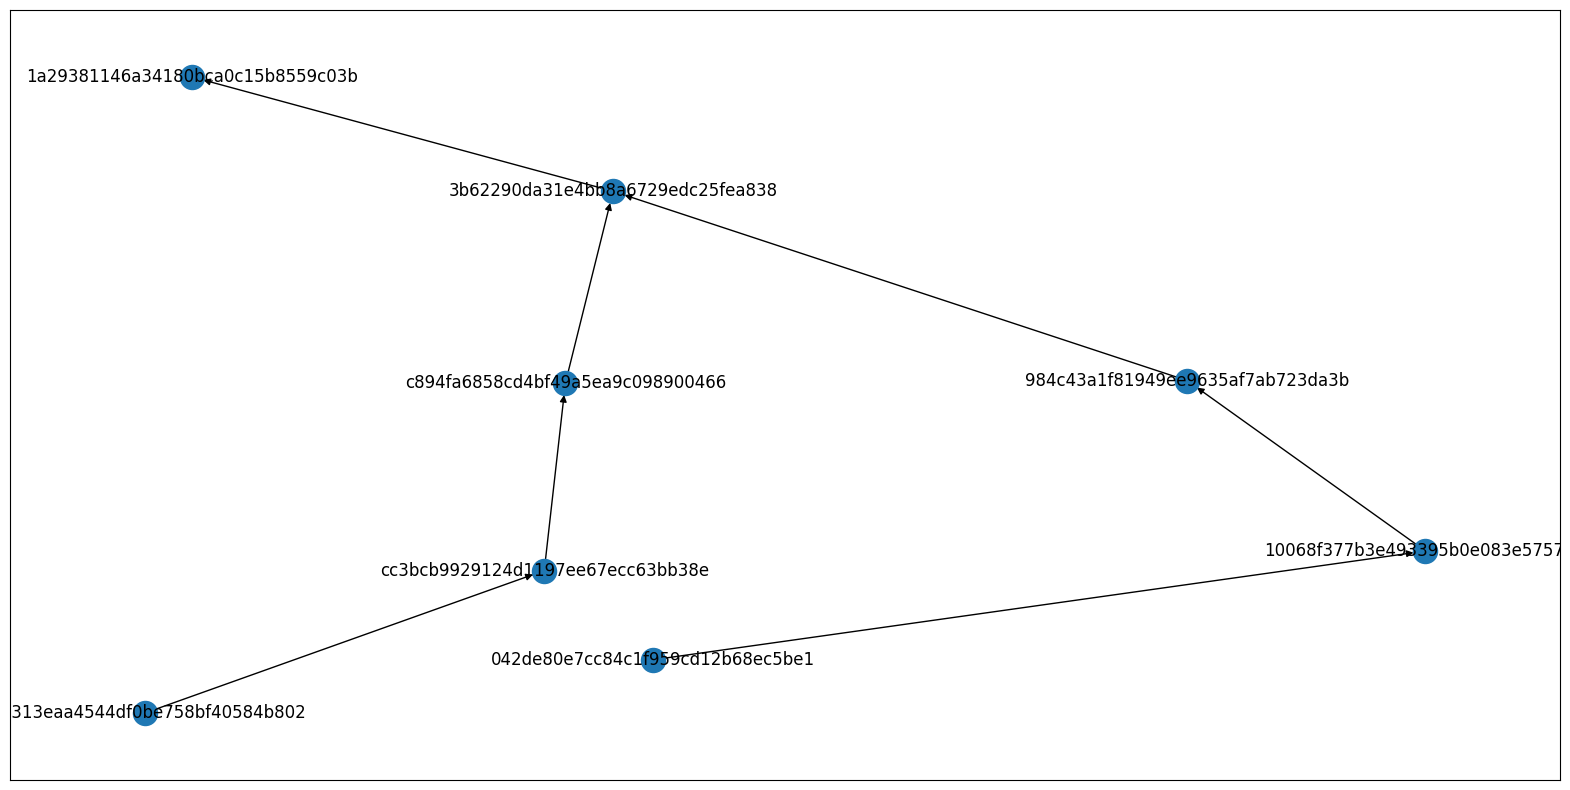

In [22]:
action_graph_service2.visualize(context=authed_context)

In [23]:
print(e)
e.id

[3 5 7]


<LineageID: 1a29381146a34180bca0c15b8559c03b - 1>

#### Scenario 4: Create a graph node when an Action is created in the `syft_make_action` method of `ActionObject`

In [2]:
worker3 = sy.Worker.named(name="test3", processes=1, reset=True)

action_service3 = worker3.get_service("actionservice")
action_graph_service3 = worker3.get_service("actiongraphservice")
root_client3 = worker3.root_client
guest_client3 = worker3.guest_client
authed_context = AuthedServiceContext(node=worker3, 
                                      credentials=worker3.signing_key.verify_key)

SQLite Store Path:
!open file:///tmp/fd61a03af4f74d878fc21e05e7e80678.sqlite



In [3]:
a = root_client3.api.lib.numpy.array([1,2,3])
# b = guest_client3.api.lib.numpy.array([1,2,3])

In [4]:
c = ActionObject.from_obj(2)

In [5]:
a*c

```python
Pointer
```
array([2, 4, 6])

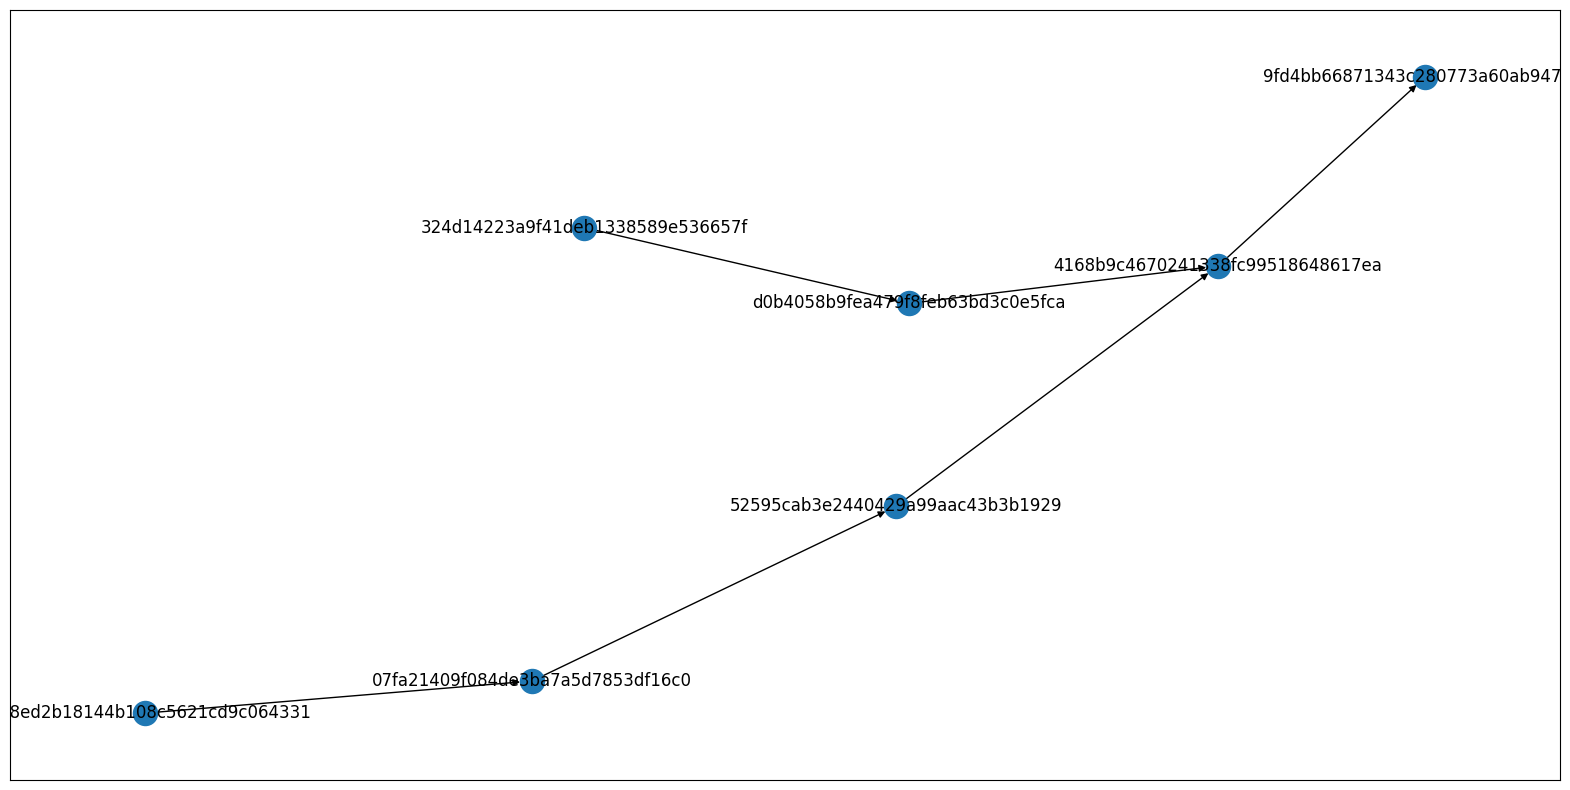

In [6]:
action_graph_service3.visualize(authed_context)

In [7]:
action_graph_service3.get_all_nodes(authed_context)

NodeDataView({<UID: 4148ed2b18144b108c5621cd9c064331>: {'data': class NodeActionData:
  id: str = 4148ed2b18144b108c5621cd9c064331
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-30 03:15:01
  updated_at: str = None
  user_verify_key: str = 8791f9ca932de8df78502b6806af5198c9fe9e686bffec50f9000ba4d6d60e40
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None
}, <UID: 07fa21409f084de3ba7a5d7853df16c0>: {'data': class NodeActionData:
  id: str = 07fa21409f084de3ba7a5d7853df16c0
  type: str = NodeType.ACTION
  status: str = ExecutionStatus.DONE
  retry: str = 0
  created_at: str = 2023-05-30 03:15:01
  updated_at: str = 2023-05-30 03:15:01
  user_verify_key: str = 8791f9ca932de8df78502b6806af5198c9fe9e686bffec50f9000ba4d6d60e40
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None
}, <U

In [8]:
action_service3.store.data

{<UID: 7a2ccd3ecd994ba088e3b1bc69027f0e>: Pointer:
[1, 2, 3], <UID: ea11367bff32460689084724e135ca54>: Pointer:
[1 2 3], <UID: f97eea1a3cc84a44be8e507ec09b8f54>: Pointer:
2, <UID: a757f3b302c2432185d58a0ad2a2fb03>: Pointer:
[2 4 6]}

In [9]:
action_service3.store.data

{<UID: 7a2ccd3ecd994ba088e3b1bc69027f0e>: Pointer:
[1, 2, 3], <UID: ea11367bff32460689084724e135ca54>: Pointer:
[1 2 3], <UID: f97eea1a3cc84a44be8e507ec09b8f54>: Pointer:
2, <UID: a757f3b302c2432185d58a0ad2a2fb03>: Pointer:
[2 4 6]}

In [3]:
orig_obj, op, args, kwargs = (set({1, 2, 3, 3}), "add", [5], {})

def helper_make_action_obj(orig_obj):
    obj_id = Action.make_id(None)
    lin_obj_id = Action.make_result_id(obj_id)
    return ActionObject.from_obj(orig_obj, id=obj_id, syft_lineage_id=lin_obj_id)

obj = helper_make_action_obj(orig_obj)
obj

```python
Pointer
```
{1, 2, 3}

In [10]:
def helper_make_action_pointers(obj, *args, **kwargs):
    root_client3.api.services.action.set(obj)
    obj_pointer = root_client3.api.services.action.get_pointer(obj.id)

    # The args and kwargs should automatically be pointerized by obj_pointer
    return obj_pointer, args, kwargs

obj_pointer, args_pointers, kwargs_pointers = helper_make_action_pointers(
    obj, *args, **kwargs
)

In [11]:
args_pointers

(5,)

In [12]:
kwargs_pointers

{}

In [13]:
path = str(type(orig_obj))
path

"<class 'set'>"

call the `syft_make_action`

In [14]:
action = obj.syft_make_action(path, op, args=args_pointers, kwargs=kwargs_pointers)
action

AttributeError: 'int' object has no attribute 'syft_node_uid'

In [59]:
action_service3.store.data

{<UID: 4178b551073f4f77b4574e01ed6b87ab>: Pointer:
{1, 2, 3}}

In [58]:
assert len(action_graph_service3.get_all_nodes(authed_context)) == 1

AssertionError: 

## `Action` update